In [41]:
%matplotlib inline 
#idk what it does

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
print("All imports successful!")

All imports successful!


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [43]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Define the Transform 
# (This converts the images to PyTorch Tensors and normalizes them 0-1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

# 2. Download and Load the Data (The "Built-in" Way)
# This automatically downloads the 0-9 digit images
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 3. Create the Loader (The Delivery Truck)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# --- VERIFICATION ---
print("Success!")
print(f"Loaded {len(train_data)} training images.")


Success!
Loaded 60000 training images.


In [44]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=64)

In [45]:
def output_label(label):
    # Get the integer value from the tensor
    input = (label.item() if type(label) == torch.Tensor else label)
    
    # Just return the string version of the number (e.g., 5 -> "5")
    return str(input)

In [46]:
a = next(iter(train_loader))
a[0].size()

torch.Size([64, 1, 28, 28])

In [47]:
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


labels:  5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 

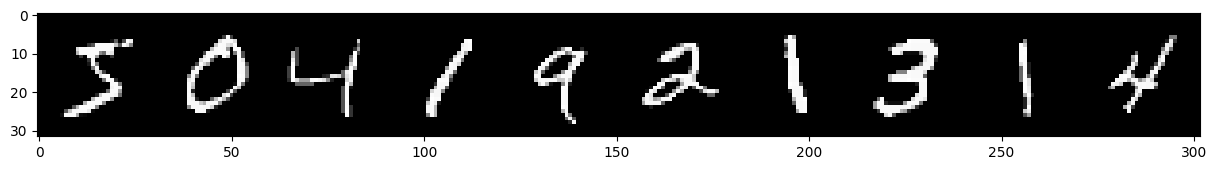

In [48]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [49]:
#the actual model

class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        self.layer1 = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        #shape: (32, 14, 14)

        self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
        #shape: (64, 7, 7)
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [50]:
model = DigitCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

DigitCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

# --- CONFIGURATION ---
num_epochs = 5
batch_size = 64
learning_rate = 0.001

# --- SETUP ---
# Re-initialize the model and optimizer so we start fresh every time we run this cell
model = DigitCNN().to(device)
error = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists for visualization
loss_list = []
iteration_list = []
accuracy_list = []

# Counter for total iterations (steps)
count = 0

print(f"Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # This creates the loading bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    # --- THE FIX: We must loop over 'loop', not 'train_loader' ---
    for i, (images, labels) in loop:
        
        # 1. Transfer to GPU
        images, labels = images.to(device), labels.to(device)
        
        # 2. Forward Pass
        outputs = model(images)
        loss = error(outputs, labels)
        
        # 3. Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count += 1
        
        # 4. Testing & Logging (Every 50 steps)
        if count % 200 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Switch to evaluate mode (Turn off Dropout)
            model.eval()
            
            with torch.no_grad(): # Don't calculate gradients for testing (Faster)
                for test_images, test_labels in test_loader:
                    test_images, test_labels = test_images.to(device), test_labels.to(device)
                    
                    test_outputs = model(test_images)
                    
                    # Get predictions
                    predicted = torch.max(test_outputs.data, 1)[1]
                    
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
            
            accuracy = 100 * correct / total
            
            # Store data for plotting
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            # Switch back to train mode (Turn on Dropout)
            model.train()
            
            # Update the loading bar with stats
            loop.set_postfix(loss=loss.item(), acc=f"{accuracy:.2f}%")
            
        if count % 500 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs} | Step: {count} | Loss: {loss.item():.4f} | Accuracy: {accuracy:.2f}%")

print("Training Complete!")

Training for 5 epochs...


Epoch 1/5:  54%|█████▎    | 502/938 [01:03<00:44,  9.90it/s, acc=96.38%, loss=0.444]

Epoch: 1/5 | Step: 500 | Loss: 0.4789 | Accuracy: 96.38%


Epoch 2/5:   7%|▋         | 64/938 [00:14<15:04,  1.04s/it, acc=98.19%, loss=0.0381]

Epoch: 2/5 | Step: 1000 | Loss: 0.0381 | Accuracy: 98.19%


Epoch 2/5:  60%|██████    | 563/938 [01:16<00:30, 12.48it/s, acc=97.88%, loss=0.0158]

Epoch: 2/5 | Step: 1500 | Loss: 0.1145 | Accuracy: 97.88%


Epoch 3/5:  14%|█▎        | 127/938 [00:20<12:54,  1.05it/s, acc=97.70%, loss=0.0149]

Epoch: 3/5 | Step: 2000 | Loss: 0.0149 | Accuracy: 97.70%


Epoch 3/5:  67%|██████▋   | 626/938 [01:27<00:28, 11.06it/s, acc=98.11%, loss=0.043] 

Epoch: 3/5 | Step: 2500 | Loss: 0.0564 | Accuracy: 98.11%


Epoch 4/5:  20%|█▉        | 187/938 [00:24<14:40,  1.17s/it, acc=98.31%, loss=0.0964]

Epoch: 4/5 | Step: 3000 | Loss: 0.0964 | Accuracy: 98.31%


Epoch 4/5:  73%|███████▎  | 688/938 [01:29<00:21, 11.59it/s, acc=98.38%, loss=0.0313]

Epoch: 4/5 | Step: 3500 | Loss: 0.0552 | Accuracy: 98.38%


Epoch 5/5:  27%|██▋       | 251/938 [00:41<12:07,  1.06s/it, acc=98.61%, loss=0.00429]

Epoch: 5/5 | Step: 4000 | Loss: 0.0043 | Accuracy: 98.61%


Epoch 5/5:  80%|███████▉  | 749/938 [4:50:38<00:25,  7.36it/s, acc=98.71%, loss=0.0477]      

Epoch: 5/5 | Step: 4500 | Loss: 0.0032 | Accuracy: 98.71%


Epoch 5/5: 100%|██████████| 938/938 [4:51:21<00:00, 18.64s/it, acc=98.18%, loss=0.0479]

Training Complete!


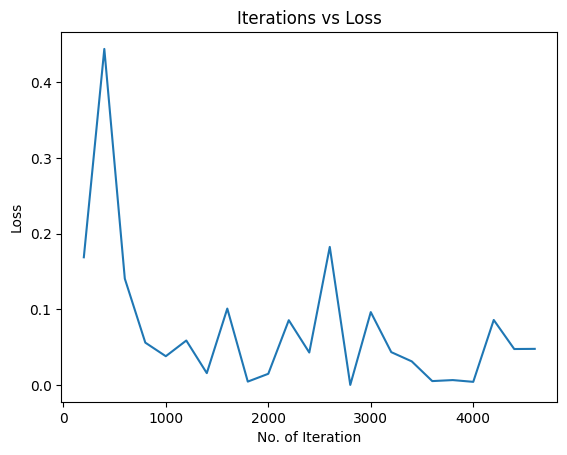

In [59]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

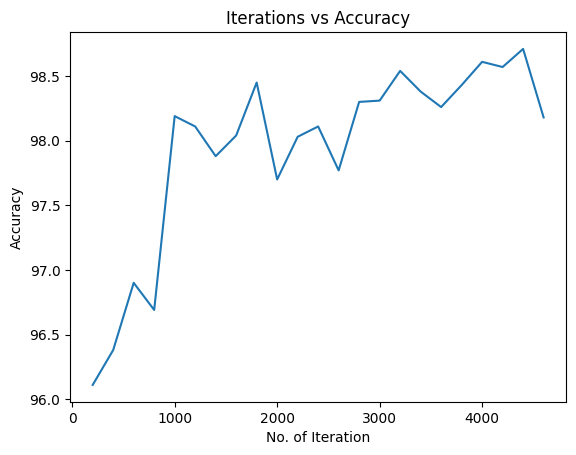

In [60]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [63]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of 0: 99.59%
Accuracy of 1: 99.65%
Accuracy of 2: 98.86%
Accuracy of 3: 99.62%
Accuracy of 4: 100.00%
Accuracy of 5: 95.37%
Accuracy of 6: 96.41%
Accuracy of 7: 98.48%
Accuracy of 8: 99.10%
Accuracy of 9: 99.62%


In [64]:
torch.save(model.state_dict(), 'my_model_weights.pth')

print("Model weights saved successfully.")

Model weights saved successfully.
